# Transformation Equations:  ComCam DP1 <--> LSSTCam

_Douglas L. Tucker, Christina L. Adair, Meagan N. Porter_

_2025.10.22_

## 1. Import Modules

In [1]:
import numpy as np
import pandas as pd

from lsst.daf.butler import Butler
import lsst.geom as geom

import pyvo

import os
import sys
import glob
import math
import datetime
import re

from collections import OrderedDict as odict

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u

import fitsio

from scipy import interpolate
from scipy.optimize import leastsq

import healpy as hp

import plotly
from plotly.offline import download_plotlyjs, plot, iplot
import plotly.graph_objs as go

from IPython.display import Markdown, display

import matplotlib.pyplot as plt

%matplotlib inline

## 2. Input Parameters

In [2]:
# ComCam-->LSSTCam (toComCam=False) or LSSTCam-->ComCam (toComCam=True)...
toComCam = True
#toComCam = False

if toComCam:
    # List of ComCam bands on which to run the transform fit...
    #bandList = ['u_ComCam', 'g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam', 'y_ComCam']
    #bandList = ['g_ComCam']
    bandList = ['g_ComCam', 'r_ComCam', 'i_ComCam', 'z_ComCam']

    # If LSSTCam-->ComCam, then the mag and color to fit against are LSSTCam...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'u_ComCam':'u_LSST', 'g_ComCam':'g_LSST', 'r_ComCam':'r_LSST', 'i_ComCam':'i_LSST', 'z_ComCam':'z_LSST', 'y_ComCam':'y_LSST'}
    # Color to fit against...
    color_name_1_dict = {'u_ComCam':'gi_LSST', 'g_ComCam':'gi_LSST', 'r_ComCam':'gi_LSST', 'i_ComCam':'gi_LSST', 'z_ComCam':'iz_LSST', 'y_ComCam':'zy_LSST'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'u_ComCam':'$(g-i)_{LSST}$', 'g_ComCam':'$(g-i)_{LSST}$', 'r_ComCam':'$(g-i)_{LSST}$', 'i_ComCam':'$(g-i)_{LSST}$', 'z_ComCam':'$(i-z)_{LSST}$', 'y_ComCam':'$(z-y)_{LSST}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...
    color_limits_1_dict = {'u_ComCam':[-10.,10.],
                           'g_ComCam':[-10.,10.], 
                           'r_ComCam':[-10.,10.], 
                           'i_ComCam':[-10.,10.],
                           'z_ComCam':[-10.,10.],
                           'y_ComCam':[-10.,10.]}

else:
    # List of LSST bands on which to run the transform fit...
    #bandList = ['u_LSST', 'g_LSST', 'r_LSST', 'i_LSST', 'z_LSST', 'y_LSST']
    bandList = ['g_LSST', 'r_LSST', 'i_LSST', 'z_LSST']
    # If ComCam-->LSST, then the mag and color to fit against are ComCam...
    # Dictionary of corresponding bands from the other survey...
    matchBand_dict = {'u_LSST':'u_ComCam', 'g_LSST':'g_ComCam', 'r_LSST':'r_ComCam', 'i_LSST':'i_ComCam', 'z_LSST':'z_ComCam', 'y_LSST':'y_ComCam'}
    # Color to fit against...
    color_name_1_dict = {'u_LSST':'u_ComCam', 'g_LSST':'gi_ComCam', 'r_LSST':'gi_ComCam', 'i_LSST':'gi_ComCam', 'z_LSST':'iz_ComCam', 'y_LSST':'zy_ComCam'}
    # Name of color_name_1 as the label in the QA plots...
    colorLabel_1_dict = {'u_LSST':'$(g-i)_{ComCam}$', 'g_LSST':'$(g-i)_{ComCam}$', 'r_LSST':'$(g-i)_{ComCam}$', 'i_LSST':'$(g-i)_{ComCam}$', 'z_LSST':'$(i-z)_{ComCam}$', 'y_LSST':'$(z-y)_{ComCam}$'}
    # Color limits defining disjoint branches of the dmag vs. color plots
    #  (each branch will be fit separately)...    
    color_limits_1_dict = {'u_LSST':[-10.,10.], 
                           'g_LSST':[-10.,10.], 
                           'r_LSST':[-10.,10.], 
                           'i_LSST':[-10.,10.],
                           'z_LSST':[-10.,10.],
                           'y_LSST':[-10.,10.]}


# Order of polynomial fits...
norder = 1

# Sigma-clipping parameters...
nsigma = 3.0
niter = 3

# ComCam data
instrument_comcam = 'LSSTComCam'
repo_comcam = 'dp1'
collection_comcam='LSSTComCam/DP1'
skymap_comcam = 'lsst_cells_v1'

# LSSTCam data
instrument_lsst = 'LSSTCam'
repo_lsst = '/repo/main'
collection_lsst = 'LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'
skymap_lsst = 'lsst_cells_v1'

#use match file?
useMatchFile = False

# Name of the match file
matchFile = '/home/d/dltucker/DATA/SP-1736/sciunit_photocalib/match_ComCam_LSSTCam_ECDFS.csv'

# Base name of fit results output file...
#if toComCam:
#    resultsFileBaseName = 'transFit.LSST_to_ComCam'
#else:
#    resultsFileBaseName = 'transFit.LSST_to_PS1DR2'

# Base name of QA plot output files...
if toComCam:
    qaFileBaseName = 'qaPlot.LSST_to_ComCam.fit'
else:
    qaFileBaseName = 'qaPlot.ComCam_to_LSST.fit'

# Write a Markdown-formatted summary table of the fits?
write_md_file = True
if write_md_file:
    # Auto-name the .md file based on qaFileBaseName
    md_filename = f"{qaFileBaseName}.qa_summary.md"

# Verbosity level (0, 1, 2, 3, ...)
verbose = 2


# From Slide 9 of https://docs.google.com/presentation/d/1NGzrT4t6wDGQ2-2a8rjioToquhx2vOP_KJTrPiCrDDY/edit#slide=id.g33de3f5c849_6_250
tract_list = [453, 454, 4849, 5063, 4848, 2394, 2234, 4016, 4017, 4218, 4217, 5525, 5526, 7611, 7610, 7850, 10463, 10464, 10704]
tract_dict={453: '47 Tuc', 
            454: '47 Tuc',
           4849: 'ECDFS', 
           5063: 'ECDFS',
           4848: 'ECDFS', 
           2394: 'EDFS', 
           2234: 'EDFS',
           4016: 'Fornax', 
           4017: 'Fornax', 
           4218: 'Fornax', 
           4217: 'Fornax', 
           5525: 'Rubin_SV_095-25', 
           5526: 'Rubin_SV_095-25', 
           7611: 'Seagull', 
           7610: 'Seagull', 
           7850: 'Seagull',
           10463: 'Rubin_SV_38_7', 
           10464: 'Rubin_SV_38_7', 
           10704: 'Rubin_SV_38_7'
           }

## 3. Define Useful Functions

In [3]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

In [4]:
def cross_match_catalogs(df1, df2, ra_name_1, dec_name_1, ra_name_2, dec_name_2):

    # Create SkyCoord objects for both dataframes
    coords1 = SkyCoord(ra=df1[ra_name_1].values*u.degree, 
                       dec=df1[dec_name_1].values*u.degree)

    coords2 = SkyCoord(ra=df2[ra_name_2].values*u.degree, 
                       dec=df2[dec_name_2].values*u.degree)

    # Match coordinates
    max_sep = 3 * u.arcsec  # Maximum separation
    idx, d2d, d3d = coords1.match_to_catalog_sky(coords2)

    # Create mask for matches within max_sep
    mask = d2d < max_sep

    # Additional mask to ensure indices are valid
    valid_idx_mask = idx[mask] < len(df2)
    combined_mask = mask.copy()
    combined_mask[mask] = valid_idx_mask
    
    # Create a new dataframe with matches
    matches = df1[combined_mask].copy()
    matches['match_idx'] = idx[combined_mask]  # Index of matching object in df2
    matches['separation_arcsec'] = d2d[combined_mask].arcsec  # Separation in arcseconds

    # Add columns from df2 for the matches
    for col in df2.columns:
        #matches[f'match_{col}'] = df2.loc[idx[mask], col].values
        # This is a safer way to to this, avoid out-of-bound indices:
        matches[f'match_{col}'] = df2.iloc[idx[combined_mask]][col].values

    # If multiple matches exist for the same source in df1, keep only the closest one
    matches = matches.loc[matches.groupby(matches.index)['separation_arcsec'].idxmin()]

    # If you want to see which objects in df1 had no matches:
    unmatched = df1[~combined_mask]

    return matches, unmatched

In [5]:
def transform1ColorQAPlots1a(dmag, color1, res, norder, title, plot1Text, dmagName, colorLabel1, rms, outputFileName):

    # Prepare QA plots...
    #fig = plt.figure(figsize=(10,5))
    #fig = plt.figure(figsize=(40,20))
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.3)
    #fig.suptitle("This is a supertitle!")
    plt.rcParams.update({'font.size': 24})

    
    # We will exclude the lowest and highets 0.01% of color1, color2, 
    #  dmag, and residuals when plotting the QA figures...
    color1_desc = color1.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    dmag_desc = dmag.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #res_desc = df.res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    res_desc = res.describe(percentiles=[0.0001, 0.001, 0.01, 0.99, 0.999, 0.9999])
    #color1_min = color1_desc['1%']
    #color1_max = color1_desc['99%']
    #color1_min = color1_desc['min']
    #color1_max = color1_desc['max']
    #dmag_min = dmag_desc['1%']
    #dmag_max = dmag_desc['99%']
    #res_min = res_desc['1%']
    #res_max = res_desc['99%']
    color1_min = color1_desc['0.01%']
    color1_max = color1_desc['99.99%']
    dmag_min = dmag_desc['0.01%']
    dmag_max = dmag_desc['99.99%']
    res_min = res_desc['0.01%']
    res_max = res_desc['99.99%']
    # What the heck; let's just set this to -0.10 mag --> +0.10 mag...
    #res_min = -0.10
    #res_max = +0.10

    
    # Plot 1:  Descriptive text...
    #plt.subplot(231)
    plt.subplot(221)
    plt.text(0.1,0.80,title,fontsize=24)
    plt.text(0.00,0.40,plot1Text,fontsize=12)
    plt.axis('off')

    
    # Plot 2:  2D hexbin histogram of dmag vs. color1...
    #plt.subplot(232) 
    plt.subplot(222)
    if len(dmag) < 1000:
        plt.scatter(color1, dmag, alpha=0.75)
        #hb=plt.hexbin(color1, dmag, gridsize=100, cmap='inferno_r')
    else:
        hb=plt.hexbin(color1, dmag, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, dmag_min, dmag_max])
    plt.xlabel(colorLabel1)
    plt.ylabel(dmagName)
    if len(dmag) >= 1000:
        cb = fig.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(color='blue')
    plt.grid(True)


    # Plot 3:  1d histogram of residuals...
    #plt.subplot(234) 
    plt.subplot(223) 
    #plt.hist(df.loc[:,'res'],bins=100)
    if len(res) < 100:
        plt.hist(res,bins=10)
    else:
        plt.hist(res,bins=100)
    plt.xlabel('residuals [mag]')
    plt.ylabel('Number')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot 4:  2d hexbin histogram of residuals vs. color1...
    #plt.subplot(235) 
    plt.subplot(224)
    if len(res) < 1000:
        plt.scatter(color1, res, alpha=0.75)
        #hb = plt.hexbin(color1, res, gridsize=100, cmap='inferno_r')
    else:
        hb = plt.hexbin(color1, res, gridsize=100, bins='log', cmap='inferno')
    plt.axis([color1_min, color1_max, res_min, res_max])
    plt.xlabel(colorLabel1)
    plt.ylabel('residuals [mag]')
    if len(res) >= 1000:
        cb = plt.colorbar(hb)
        cb.set_label('log10(N)')
    plt.grid(True)
    plt.grid(color='blue')

    
    # Plot...
    plt.tight_layout()
    #plt.show()
    plt.savefig(outputFileName)

    return 0


##################################


In [6]:
# Kudos to Claude-3.5-Sonnet for improving on old outlier rejection code...

def poly_fit_with_sigma_clip(x, y, degree=1, sigma=3.0, maxiters=5):
    """
    Perform polynomial fit with iterative sigma clipping
    
    Parameters:
    -----------
    x : array-like
        Independent variable
    y : array-like 
        Dependent variable
    degree : int
        Degree of polynomial fit
    sigma : float
        Sigma clipping threshold
    maxiters : int
        Maximum number of sigma clipping iterations
        
    Returns:
    --------
    coeffs : array
        Polynomial coefficients
    mask : array
        Boolean mask indicating non-clipped points
    rms : float
        RMS of residuals
    """

    # Import relevant modules
    import numpy as np
    from astropy.stats import sigma_clip
    
    # Initial fit using all points
    x = np.asarray(x)
    y = np.asarray(y)
    mask = np.ones_like(x, dtype=bool)
    
    for _ in range(maxiters):
        print(len(x[mask]), len(y[mask]), len(mask))

        # Fit polynomial to non-masked points
        coeffs, cov = np.polyfit(x[mask], y[mask], degree, cov=True)
        
        # Calculate residuals
        yfit = np.polyval(coeffs, x)
        residuals = y - yfit
        
        # Update mask with sigma clipping
        new_mask = ~sigma_clip(residuals, sigma=sigma).mask
        
        # Check for convergence
        if np.array_equal(mask, new_mask):
            break
        
        mask = new_mask
    
    # Calculate final RMS
    final_residuals = y[mask] - np.polyval(coeffs, x[mask])
    rms = np.sqrt(np.mean(final_residuals**2))

    print(len(x[mask]), len(y[mask]), len(mask))

    # Calculate coefficient errors from diagonal of covariance matrix
    coeff_errors = np.sqrt(np.diag(cov))
        
    return coeffs, coeff_errors, x[mask], y[mask], final_residuals, rms

In [7]:
# Kudos to Copilot ChatGPT-5 for these functions for generating Markdown output 
#  of the fit equations...
# See:  https://copilot.microsoft.com/shares/Nopgin8hutEqEmjqJkteY

def latexify_label(label: str) -> str:
    """Strip $ and convert underscores to LaTeX subscripts."""
    label = label.strip('$')
    return re.sub(r'_(\w+)', r'_{\1}', label)

def latexify_name(name: str) -> str:
    """Convert underscores in names to LaTeX subscripts."""
    return re.sub(r'_(\w+)', r'_{\1}', name)

def make_eq_str(dmagName, p_branch, colorLabel_1, norder):
    """
    Build a LaTeX-formatted transformation equation for Markdown.
    Ensures all terms are inside a single $...$ block with proper signs.
    """
    label = latexify_label(colorLabel_1)           # e.g., (g-i)_{ComCam}
    dmagName_math = latexify_name(dmagName)        # e.g., U - u_{ComCam}

    terms = []
    power = norder
    for coeff in p_branch:
        if power == 0:
            # Constant term: no variable
            terms.append(f"{coeff:+.3f}")
        elif power == 1:
            # Linear term
            terms.append(f"{coeff:+.3f} {label}")
        else:
            terms.append(f"{coeff:+.3f} {label}^{power}")
            # Higher-order term
        power -= 1

    # Join all terms with spaces; signs are already included in coeff formatting
    eq_body = " ".join(terms)
    return f"${dmagName_math} = {eq_body}$"

def make_range_str(color_limits, colorLabel_1, ibranch):
    label = latexify_label(colorLabel_1)
    # Use LaTeX \leq for "less than or equal to"
    return (f"${color_limits[ibranch]:.1f} < {label} \\leq "
            f"{color_limits[ibranch+1]:.1f}$")

def make_output_filename(base, magName, magName_match, color_name_1, norder):
    return f"{base}.dmag_{magName}-{magName_match}.{color_name_1}.norder{norder}.qa1.png"


In [8]:
# Kudos to Copilot ChatGPT-5 for improving the plot text generation

def make_plot_text(dmagName, p_branch, colorLabel_1, norder,
                   color_limits, ibranch, stddev_branch):
    """
    Build a descriptive text string for plots, valid for any polynomial order.
    Example output:
    "g - r = -0.041 -0.302*(g-i)   [0.2 < (g-i) <= 2.5]   [rms: 0.022]"
    """
    terms = []
    power = norder
    for coeff in p_branch:
        if power == 0:
            # Constant term, but still include sign
            terms.append(f"{coeff:+.3f}")
        elif power == 1:
            terms.append(f"{coeff:+.3f}*{colorLabel_1}")
        else:
            terms.append(f"{coeff:+.3f}*{colorLabel_1}^{power}")
        power -= 1

    poly_str = " ".join(terms)

    lo = color_limits[ibranch]
    hi = color_limits[ibranch+1]
    range_str = f"[{lo:.1f} < {colorLabel_1} <= {hi:.1f}]"
    rms_str = f"[rms: {stddev_branch:.3f}]"

    return f"{dmagName} = {poly_str}  {range_str}  {rms_str}"

## X. Read in Matched Catalog

In [9]:
#matchFile = os.path.join(matchDir,matchFile)
#print(matchFile)

In [10]:
## Check to make sure matchFile exists...
if useMatchFile:
    if os.path.isfile(matchFile)==False:
        print("""ERROR:  matchFile %s does not exist...""" % (matchFile))
    if verbose > 0:
        print('matchFile: ', matchFile)


In [11]:
if useMatchFile:
    tab = Table.read(matchFile, format='csv')
    tab

In [12]:
if useMatchFile:
    matches = tab.to_pandas()
    matches

## 4. Query ComCam Catalog

In [13]:
# Create two butlers, one including the skymap.
#  (Creating two should not be necessary, but...)
if not useMatchFile:
    butler_comcam = Butler(repo_comcam, collections=collection_comcam)
    skybutler_comcam = Butler(repo_comcam, collections=collection_comcam, skymap=skymap_comcam)

In [14]:
# Define which of the nearly 1000 columns to download from the ComCam ObjectTable...
if not useMatchFile:
    INCOLS = [
        'coord_ra',
        'coord_dec',
    ]
    bands="ugrizy"
    for band in bands:
        INCOLS += [
            f'{band}_psfFlux',
            f'{band}_psfFluxErr',
            f'{band}_ap12Flux',
            f'{band}_ap12FluxErr',
            f'{band}_extendedness',
            f'{band}_psfFlux_flag'
        ]


In [15]:
# Download stars from the Extended Chandra Deep Field South (ECDFS)...
if not useMatchFile:
    comcam_stars_list = []

    for tractId in tract_list:

        #if tract_dict[tractId] != 'ECDFS':
        #    continue

        print(tractId, tract_dict[tractId])

        try:
    
            raw_comcam = butler_comcam.get('object', dataId={'skymap': 'lsst_cells_v1', 'tract': tractId}, 
                                        collections=[collection_comcam],
                                        parameters={"columns":INCOLS}).to_pandas()

            # Insert tractId as the first column
            raw_comcam.insert(0, 'tractId', tractId)  
    
            # Insert field name -- if known -- as the second column
            if tractId in tract_dict:
                field = tract_dict[tractId]
            else:
                field = 'unknown'
            raw_comcam.insert(1, 'field', field)  

            # Clean the catalog
            #sel  = (raw_comcam['detect_isPrimary'] == True)
            sel = (raw_comcam['r_psfFlux']/raw_comcam['r_psfFluxErr'] > 5)
            for band in ['g','r','i']:
                sel &= (raw_comcam[f'{band}_psfFlux_flag'] == 0)

            comcam = raw_comcam[sel]

            # Find just the (most likely) stars...
            sel_comcam_stars = (comcam['g_extendedness'] < 0.5) & (comcam['r_extendedness'] < 0.5)
            comcam_stars = comcam[sel_comcam_stars] 
            print(f"Number of objects: {len(comcam)}")
            print(f"Number of stars: {len(comcam_stars)}")

            # Append the dataframe to the list
            comcam_stars_list.append(comcam_stars) 

        # Catch any exception
        except Exception as e:

            print(f"An error occurred for tractId {tractId}: {e}")


    # Concatenate all dataframes in the list
    comcam_stars_all = pd.concat(comcam_stars_list, ignore_index=True)  
    print(f"Total number of stars: {len(comcam_stars_all)}")


453 47 Tuc
Number of objects: 49962
Number of stars: 9872
454 47 Tuc
Number of objects: 966
Number of stars: 117
4849 ECDFS
Number of objects: 58807
Number of stars: 2433
5063 ECDFS
Number of objects: 206560
Number of stars: 7859
4848 ECDFS
Number of objects: 32195
Number of stars: 1318
2394 EDFS
Number of objects: 175982
Number of stars: 7512
2234 EDFS
Number of objects: 21753
Number of stars: 1222
4016 Fornax
Number of objects: 85646
Number of stars: 11461
4017 Fornax
Number of objects: 31061
Number of stars: 3069
4218 Fornax
Number of objects: 39239
Number of stars: 4667
4217 Fornax
Number of objects: 7572
Number of stars: 725
5525 Rubin_SV_095-25
Number of objects: 47315
Number of stars: 5734
5526 Rubin_SV_095-25
Number of objects: 114403
Number of stars: 13794
7611 Seagull
Number of objects: 0
Number of stars: 0
7610 Seagull
Number of objects: 0
Number of stars: 0
7850 Seagull
Number of objects: 0
Number of stars: 0
10463 Rubin_SV_38_7
Number of objects: 135287
Number of stars: 67

In [16]:
if not useMatchFile:
    display(comcam_stars_all)


,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag
0,453,47 Tuc,6.303627,-72.653795,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,9114.306641,2062.754639,8919.085938,3599.792969,NaN,False
1,453,47 Tuc,6.309739,-72.653075,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,1254.011963,2056.789795,1319.518555,3404.657471,NaN,False
2,453,47 Tuc,6.302208,-72.650254,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,5069.709473,2043.248169,3843.699463,3587.240723,0.0,False
3,453,47 Tuc,6.324509,-72.644589,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,631.916687,2031.678589,1752.389771,3578.502930,1.0,False
4,453,47 Tuc,6.310525,-72.641721,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,2572.493164,2013.775391,2981.951416,3566.965332,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82353,10704,Rubin_SV_38_7,37.476900,7.871195,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82354,10704,Rubin_SV_38_7,37.462033,7.879292,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82355,10704,Rubin_SV_38_7,37.414867,7.879871,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82356,10704,Rubin_SV_38_7,37.457100,7.889724,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True


In [17]:
# Find the bounding (ra,dec)'s for the ComCam EDFS field: 
if not useMatchFile:
    ra_min = comcam_stars_all.coord_ra.min()
    ra_max = comcam_stars_all.coord_ra.max()
    dec_min = comcam_stars_all.coord_dec.min()
    dec_max = comcam_stars_all.coord_dec.max()

    print(ra_min, ra_max, dec_min, dec_max)

4.339320403393294 95.70060612307906 -72.66605865167178 7.969936691740922


## 5. Query LSSTCam Catalog

In [18]:
# Create two butlers, one including the skymap.
#  (Creating two should not be necessary, but...)
if not useMatchFile:
    butler_lsst = Butler(repo_lsst, collections=collection_lsst)
    skybutler_lsst = Butler(repo_lsst, collections=collection_lsst, skymap=skymap_lsst)


In [19]:
# Define which of the nearly 1000 columns to download from the LSSTCam ObjectTable...
if not useMatchFile:
    INCOLS = [
        'coord_ra',
        'coord_dec',
    ]
    bands="ugrizy"
    for band in bands:
        INCOLS += [
            f'{band}_psfFlux',
            f'{band}_psfFluxErr',
            f'{band}_ap12Flux',
            f'{band}_ap12FluxErr',
            f'{band}_extendedness',
            f'{band}_psfFlux_flag'
        ]


In [20]:
# Download stars from the Extended Chandra Deep Field South (ECDFS)...
if not useMatchFile:
    lsst_stars_list = []

    for tractId in tract_list:

        #if tract_dict[tractId] != 'ECDFS':
        #    continue

        print(tractId, tract_dict[tractId])

        try:
    
            raw_lsst = butler_lsst.get('object', dataId={'skymap': 'lsst_cells_v1', 'tract': tractId}, 
                                        collections=[collection_lsst],
                                        parameters={"columns":INCOLS}).to_pandas()

            # Insert tractId as the first column
            raw_lsst.insert(0, 'tractId', tractId)  
    
            # Insert field name -- if known -- as the second column
            if tractId in tract_dict:
                field = tract_dict[tractId]
            else:
                field = 'unknown'
            raw_lsst.insert(1, 'field', field)  

            # Clean the catalog
            #sel  = (raw_lsst['detect_isPrimary'] == True)
            sel = (raw_lsst['r_psfFlux']/raw_lsst['r_psfFluxErr'] > 5)
            for band in ['g','r','i']:
                sel &= (raw_lsst[f'{band}_psfFlux_flag'] == 0)

            lsst = raw_lsst[sel]

            # Find just the (most likely) stars...
            sel_lsst_stars = (lsst['g_extendedness'] < 0.5) & (lsst['r_extendedness'] < 0.5)
            lsst_stars = lsst[sel_lsst_stars] 
            print(f"Number of objects: {len(lsst)}")
            print(f"Number of stars: {len(lsst_stars)}")

            # Append the dataframe to the list
            lsst_stars_list.append(lsst_stars) 

        # Catch any exception
        except Exception as e:

            print(f"An error occurred for tractId {tractId}: {e}")


    # Concatenate all dataframes in the list
    lsst_stars_all = pd.concat(lsst_stars_list, ignore_index=True)  
    print(f"Total number of stars: {len(lsst_stars_all)}")

    # Not needed, as the match function prepends "match_" to the column names of 
    #  the LSST columns.
    ## Append "_lsst" to the name of each column in lsst_stars_list
    #lsst_stars_all.columns = [col + "_lsst" for col in lsst_stars_all.columns]


453 47 Tuc
An error occurred for tractId 453: Dataset object with data ID {skymap: 'lsst_cells_v1', tract: 453} could not be found in collections ['LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'].
454 47 Tuc
An error occurred for tractId 454: Dataset object with data ID {skymap: 'lsst_cells_v1', tract: 454} could not be found in collections ['LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'].
4849 ECDFS
Number of objects: 266866
Number of stars: 10495
5063 ECDFS
Number of objects: 313293
Number of stars: 12435
4848 ECDFS
Number of objects: 272644
Number of stars: 10372
2394 EDFS
Number of objects: 274143
Number of stars: 14291
2234 EDFS
Number of objects: 273479
Number of stars: 13896
4016 Fornax
An error occurred for tractId 4016: Dataset object with data ID {skymap: 'lsst_cells_v1', tract: 4016} could not be found in collections ['LSSTCam/runs/DRP/20250604_20250921/w_2025_39/DM-52645'].
4017 Fornax
An error occurred for tractId 4017: Dataset object with data ID {skymap:

In [21]:
# Find the bounding (ra,dec)'s for the LSSTam EDFS field: 
if not useMatchFile:
    ra_min = lsst_stars_all.coord_ra.min()
    ra_max = lsst_stars_all.coord_ra.max()
    dec_min = lsst_stars_all.coord_dec.min()
    dec_max = lsst_stars_all.coord_dec.max()

    print(ra_min, ra_max, dec_min, dec_max)

51.30852867332913 60.365695071309084 -50.578422745007494 -26.77694544404864


In [22]:
if not useMatchFile:
    display(lsst_stars_all)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag
0,4849,ECDFS,53.870067,-29.729633,NaN,NaN,NaN,NaN,NaN,True,...,2651.142578,679.854370,1.0,False,NaN,NaN,NaN,NaN,NaN,True
1,4849,ECDFS,53.868493,-29.726706,NaN,NaN,NaN,NaN,NaN,True,...,29397.498047,682.803162,0.0,False,NaN,NaN,NaN,NaN,NaN,True
2,4849,ECDFS,53.858474,-29.720499,NaN,NaN,NaN,NaN,NaN,True,...,25812.544922,679.012390,0.0,False,NaN,NaN,NaN,NaN,NaN,True
3,4849,ECDFS,53.898701,-29.714419,NaN,NaN,NaN,NaN,NaN,True,...,128.496277,760.577637,NaN,False,NaN,NaN,NaN,NaN,NaN,True
4,4849,ECDFS,53.901397,-29.709076,NaN,NaN,NaN,NaN,NaN,True,...,3130.757080,756.175842,1.0,False,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61484,2234,EDFS,57.780379,-49.098458,NaN,NaN,NaN,NaN,NaN,True,...,16730.148438,352.200623,0.0,False,NaN,NaN,NaN,NaN,NaN,True
61485,2234,EDFS,57.807121,-49.097509,NaN,NaN,NaN,NaN,NaN,True,...,8124.820312,372.061584,0.0,False,NaN,NaN,NaN,NaN,NaN,True
61486,2234,EDFS,57.808072,-49.094605,NaN,NaN,NaN,NaN,NaN,True,...,279720.656250,406.076630,0.0,False,NaN,NaN,NaN,NaN,NaN,True
61487,2234,EDFS,57.843170,-49.098116,NaN,NaN,NaN,NaN,NaN,True,...,2371.245850,579.808777,NaN,False,NaN,NaN,NaN,NaN,NaN,True


## 6. Match ComCam and LSSTcam stars

In [23]:
if not useMatchFile:
    matches, unmatched = cross_match_catalogs(comcam_stars_all, lsst_stars_all, 
                                              'coord_ra', 'coord_dec', 
                                              'coord_ra', 'coord_dec')

In [24]:
if not useMatchFile:
    display(matches)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,match_z_ap12Flux,match_z_ap12FluxErr,match_z_extendedness,match_z_psfFlux_flag,match_y_psfFlux,match_y_psfFluxErr,match_y_ap12Flux,match_y_ap12FluxErr,match_y_extendedness,match_y_psfFlux_flag
9989,4849,ECDFS,53.305439,-28.694426,102.622742,362.713531,202.669632,746.471375,NaN,False,...,8233.354492,248.500366,1.0,False,NaN,NaN,NaN,NaN,NaN,True
9990,4849,ECDFS,53.271986,-28.674615,13477.228516,417.236908,14691.198242,766.648560,0.0,False,...,47538.289062,262.213898,0.0,False,NaN,NaN,NaN,NaN,NaN,True
9993,4849,ECDFS,53.325036,-28.698507,NaN,NaN,207.160324,inf,NaN,True,...,167148.281250,271.244385,0.0,False,NaN,NaN,NaN,NaN,NaN,True
9994,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,366576.656250,277.587036,0.0,False,NaN,NaN,NaN,NaN,NaN,True
9996,4849,ECDFS,53.285193,-28.677182,13077.781250,419.588928,13689.464844,767.839722,0.0,False,...,95497.046875,257.218353,0.0,False,NaN,NaN,NaN,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30320,2234,EDFS,58.592220,-49.108123,551.590210,354.660004,542.824463,598.304749,NaN,False,...,5851.713867,464.002258,1.0,False,NaN,NaN,NaN,NaN,NaN,True
30324,2234,EDFS,58.497784,-49.105854,NaN,NaN,294.932404,10.994769,NaN,True,...,90688.062500,363.460022,0.0,False,NaN,NaN,NaN,NaN,NaN,True
30325,2234,EDFS,58.479871,-49.101866,NaN,NaN,294.934540,10.993175,NaN,True,...,27316.822266,359.513123,0.0,False,NaN,NaN,NaN,NaN,NaN,True
30326,2234,EDFS,58.511756,-49.099982,NaN,NaN,294.933624,10.999981,NaN,True,...,17133.394531,358.278137,0.0,False,NaN,NaN,NaN,NaN,NaN,True


In [25]:
matches.columns

Index(['tractId', 'field', 'coord_ra', 'coord_dec', 'u_psfFlux',
       'u_psfFluxErr', 'u_ap12Flux', 'u_ap12FluxErr', 'u_extendedness',
       'u_psfFlux_flag', 'g_psfFlux', 'g_psfFluxErr', 'g_ap12Flux',
       'g_ap12FluxErr', 'g_extendedness', 'g_psfFlux_flag', 'r_psfFlux',
       'r_psfFluxErr', 'r_ap12Flux', 'r_ap12FluxErr', 'r_extendedness',
       'r_psfFlux_flag', 'i_psfFlux', 'i_psfFluxErr', 'i_ap12Flux',
       'i_ap12FluxErr', 'i_extendedness', 'i_psfFlux_flag', 'z_psfFlux',
       'z_psfFluxErr', 'z_ap12Flux', 'z_ap12FluxErr', 'z_extendedness',
       'z_psfFlux_flag', 'y_psfFlux', 'y_psfFluxErr', 'y_ap12Flux',
       'y_ap12FluxErr', 'y_extendedness', 'y_psfFlux_flag', 'match_idx',
       'separation_arcsec', 'match_tractId', 'match_field', 'match_coord_ra',
       'match_coord_dec', 'match_u_psfFlux', 'match_u_psfFluxErr',
       'match_u_ap12Flux', 'match_u_ap12FluxErr', 'match_u_extendedness',
       'match_u_psfFlux_flag', 'match_g_psfFlux', 'match_g_psfFluxErr',
     

In [26]:
if not useMatchFile:
    matches.to_csv(matchFile,index=False)

In [27]:
if not useMatchFile:
    display(unmatched)

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,z_ap12Flux,z_ap12FluxErr,z_extendedness,z_psfFlux_flag,y_psfFlux,y_psfFluxErr,y_ap12Flux,y_ap12FluxErr,y_extendedness,y_psfFlux_flag
0,453,47 Tuc,6.303627,-72.653795,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,9114.306641,2062.754639,8919.085938,3599.792969,NaN,False
1,453,47 Tuc,6.309739,-72.653075,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,1254.011963,2056.789795,1319.518555,3404.657471,NaN,False
2,453,47 Tuc,6.302208,-72.650254,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,5069.709473,2043.248169,3843.699463,3587.240723,0.0,False
3,453,47 Tuc,6.324509,-72.644589,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,631.916687,2031.678589,1752.389771,3578.502930,1.0,False
4,453,47 Tuc,6.310525,-72.641721,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,2572.493164,2013.775391,2981.951416,3566.965332,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82353,10704,Rubin_SV_38_7,37.476900,7.871195,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82354,10704,Rubin_SV_38_7,37.462033,7.879292,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82355,10704,Rubin_SV_38_7,37.414867,7.879871,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True
82356,10704,Rubin_SV_38_7,37.457100,7.889724,NaN,NaN,NaN,NaN,NaN,True,...,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,True


##  7. Add ABmag Columns to Matched Catalog Data Frame

In [28]:
# Copy matches to df...
df = matches.copy()

In [29]:
# Define common parameters
flux_bands = ['u', 'g', 'r', 'i', 'z', 'y']
offset = 31.4 # For magnitude calculation
sentinel_value = -9999.0

# Loop through each band to calculate both magnitude and magnitude error
for band in flux_bands:

    # For ComCam:
    
    flux_col = f'{band}_psfFlux'
    flux_err_col = f'{band}_psfFluxErr'
    mag_col = f'{band}_psfMag'
    mag_err_col = f'{band}_psfMagErr'

    # Condition for valid flux (must be positive for log10 and division)
    valid_flux_condition = df[flux_col] > 0

    # Calculate magnitude
    df[mag_col] = np.where(valid_flux_condition,
                           -2.5 * np.log10(df[flux_col]) + offset,
                           sentinel_value)

    # Calculate magnitude error
    df[mag_err_col] = np.where(valid_flux_condition,
                               1.086 * df[flux_err_col] / df[flux_col],
                               sentinel_value)

    # For LSST:
    
    flux_col = f'match_{band}_psfFlux'
    flux_err_col = f'match_{band}_psfFluxErr'
    mag_col = f'match_{band}_psfMag'
    mag_err_col = f'match_{band}_psfMagErr'

    # Condition for valid flux (must be positive for log10 and division)
    valid_flux_condition = df[flux_col] > 0

    # Calculate magnitude
    df[mag_col] = np.where(valid_flux_condition,
                           -2.5 * np.log10(df[flux_col]) + offset,
                           sentinel_value)

    # Calculate magnitude error
    df[mag_err_col] = np.where(valid_flux_condition,
                               1.086 * df[flux_err_col] / df[flux_col],
                               sentinel_value)



/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10

/opt/lsst/software/stack/conda/envs/lsst-scipipe-10.1.0/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log10



In [30]:
df

,tractId,field,coord_ra,coord_dec,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,match_i_psfMag,match_i_psfMagErr,z_psfMag,z_psfMagErr,match_z_psfMag,match_z_psfMagErr,y_psfMag,y_psfMagErr,match_y_psfMag,match_y_psfMagErr
9989,4849,ECDFS,53.305439,-28.694426,102.622742,362.713531,202.669632,746.471375,NaN,False,...,22.080452,0.013275,-9999.000000,-9999.000000,21.686434,0.016202,-9999.000000,-9999.000000,-9999.0,-9999.0
9990,4849,ECDFS,53.271986,-28.674615,13477.228516,417.236908,14691.198242,766.648560,0.0,False,...,19.734661,0.001804,19.694149,0.007938,19.710661,0.003099,-9999.000000,-9999.000000,-9999.0,-9999.0
9993,4849,ECDFS,53.325036,-28.698507,NaN,NaN,207.160324,inf,NaN,True,...,18.391026,0.000805,-9999.000000,-9999.000000,18.347134,0.001050,-9999.000000,-9999.000000,-9999.0,-9999.0
9994,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,17.987839,0.000552,17.489765,0.002416,17.498190,0.000567,-9999.000000,-9999.000000,-9999.0,-9999.0
9996,4849,ECDFS,53.285193,-28.677182,13077.781250,419.588928,13689.464844,767.839722,0.0,False,...,19.034370,0.001077,18.931782,0.006447,18.960308,0.001542,-9999.000000,-9999.000000,-9999.0,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30320,2234,EDFS,58.592220,-49.108123,551.590210,354.660004,542.824463,598.304749,NaN,False,...,22.095322,0.013690,22.080263,0.033887,22.050987,0.043464,21.960539,0.081372,-9999.0,-9999.0
30324,2234,EDFS,58.497784,-49.105854,NaN,NaN,294.932404,10.994769,NaN,True,...,19.790260,0.002237,18.981216,0.003312,18.994368,0.002335,18.605736,0.006428,-9999.0,-9999.0
30325,2234,EDFS,58.479871,-49.101866,NaN,NaN,294.934540,10.993175,NaN,True,...,20.983446,0.005358,20.331314,0.009130,20.330420,0.006961,20.035219,0.020889,-9999.0,-9999.0
30326,2234,EDFS,58.511756,-49.099982,NaN,NaN,294.933624,10.999981,NaN,True,...,20.786486,0.004676,20.805504,0.017149,20.789068,0.010410,20.866238,0.061682,-9999.0,-9999.0


In [31]:
# Rename columns...
df.rename(columns={'coord_ra':'RA_ComCam',
                   'coord_dec':'DEC_ComCam',
                   'u_psfMag':'u_ComCam',
                   'g_psfMag':'g_ComCam',
                   'r_psfMag':'r_ComCam',
                   'i_psfMag':'i_ComCam',
                   'z_psfMag':'z_ComCam',
                   'y_psfMag':'y_ComCam',
                   'u_psfMagErr':'u_err_ComCam',
                   'g_psfMagErr':'g_err_ComCam',
                   'r_psfMagErr':'r_err_ComCam',
                   'i_psfMagErr':'i_err_ComCam',
                   'z_psfMagErr':'z_err_ComCam',
                   'y_psfMagErr':'y_err_ComCam',
                   'match_coord_ra':'RA_LSST',
                   'match_coord_dec':'DEC_LSST',
                   'match_u_psfMag':'u_LSST',
                   'match_g_psfMag':'g_LSST',
                   'match_r_psfMag':'r_LSST',
                   'match_i_psfMag':'i_LSST',
                   'match_z_psfMag':'z_LSST',
                   'match_y_psfMag':'y_LSST',
                   'match_u_psfMagErr':'u_err_LSST',
                   'match_g_psfMagErr':'g_err_LSST',
                   'match_r_psfMagErr':'r_err_LSST',
                   'match_i_psfMagErr':'i_err_LSST',
                   'match_z_psfMagErr':'z_err_LSST',
                   'match_y_psfMagErr':'y_err_LSST'
                  },inplace=True)

df.head(5)

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,i_LSST,i_err_LSST,z_ComCam,z_err_ComCam,z_LSST,z_err_LSST,y_ComCam,y_err_ComCam,y_LSST,y_err_LSST
9989,4849,ECDFS,53.305439,-28.694426,102.622742,362.713531,202.669632,746.471375,NaN,False,...,22.080452,0.013275,-9999.000000,-9999.000000,21.686434,0.016202,-9999.0,-9999.0,-9999.0,-9999.0
9990,4849,ECDFS,53.271986,-28.674615,13477.228516,417.236908,14691.198242,766.648560,0.0,False,...,19.734661,0.001804,19.694149,0.007938,19.710661,0.003099,-9999.0,-9999.0,-9999.0,-9999.0
9993,4849,ECDFS,53.325036,-28.698507,NaN,NaN,207.160324,inf,NaN,True,...,18.391026,0.000805,-9999.000000,-9999.000000,18.347134,0.001050,-9999.0,-9999.0,-9999.0,-9999.0
9994,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,17.987839,0.000552,17.489765,0.002416,17.498190,0.000567,-9999.0,-9999.0,-9999.0,-9999.0
9996,4849,ECDFS,53.285193,-28.677182,13077.781250,419.588928,13689.464844,767.839722,0.0,False,...,19.034370,0.001077,18.931782,0.006447,18.960308,0.001542,-9999.0,-9999.0,-9999.0,-9999.0


In [32]:
for col in df.columns:
    print(col)

tractId
field
RA_ComCam
DEC_ComCam
u_psfFlux
u_psfFluxErr
u_ap12Flux
u_ap12FluxErr
u_extendedness
u_psfFlux_flag
g_psfFlux
g_psfFluxErr
g_ap12Flux
g_ap12FluxErr
g_extendedness
g_psfFlux_flag
r_psfFlux
r_psfFluxErr
r_ap12Flux
r_ap12FluxErr
r_extendedness
r_psfFlux_flag
i_psfFlux
i_psfFluxErr
i_ap12Flux
i_ap12FluxErr
i_extendedness
i_psfFlux_flag
z_psfFlux
z_psfFluxErr
z_ap12Flux
z_ap12FluxErr
z_extendedness
z_psfFlux_flag
y_psfFlux
y_psfFluxErr
y_ap12Flux
y_ap12FluxErr
y_extendedness
y_psfFlux_flag
match_idx
separation_arcsec
match_tractId
match_field
RA_LSST
DEC_LSST
match_u_psfFlux
match_u_psfFluxErr
match_u_ap12Flux
match_u_ap12FluxErr
match_u_extendedness
match_u_psfFlux_flag
match_g_psfFlux
match_g_psfFluxErr
match_g_ap12Flux
match_g_ap12FluxErr
match_g_extendedness
match_g_psfFlux_flag
match_r_psfFlux
match_r_psfFluxErr
match_r_ap12Flux
match_r_ap12FluxErr
match_r_extendedness
match_r_psfFlux_flag
match_i_psfFlux
match_i_psfFluxErr
match_i_ap12Flux
match_i_ap12FluxErr
match_i_exte

## 8. Add Color Columns to Matched Catalog Data Frame

In [33]:
# Add color columns...
df.loc[:,'gr_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'r_ComCam']
df.loc[:,'ri_ComCam'] = df.loc[:,'r_ComCam'] - df.loc[:,'i_ComCam']
df.loc[:,'iz_ComCam'] = df.loc[:,'i_ComCam'] - df.loc[:,'z_ComCam']
df.loc[:,'zy_ComCam'] = df.loc[:,'z_ComCam'] - df.loc[:,'y_ComCam']
df.loc[:,'gi_ComCam'] = df.loc[:,'g_ComCam'] - df.loc[:,'i_ComCam']

df.loc[:,'gr_LSST'] = df.loc[:,'g_LSST'] - df.loc[:,'r_LSST']
df.loc[:,'ri_LSST'] = df.loc[:,'r_LSST'] - df.loc[:,'i_LSST']
df.loc[:,'iz_LSST'] = df.loc[:,'i_LSST'] - df.loc[:,'z_LSST']
df.loc[:,'zy_LSST'] = df.loc[:,'z_LSST'] - df.loc[:,'y_LSST']
df.loc[:,'gi_LSST'] = df.loc[:,'g_LSST'] - df.loc[:,'i_LSST']


In [34]:
# Insert dmag column...
df.loc[:,'dmag'] = -9999.

In [35]:
df

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,ri_ComCam,iz_ComCam,zy_ComCam,gi_ComCam,gr_LSST,ri_LSST,iz_LSST,zy_LSST,gi_LSST,dmag
9989,4849,ECDFS,53.305439,-28.694426,102.622742,362.713531,202.669632,746.471375,NaN,False,...,1.000391,10021.061523,0.000000,1.982399,1.099613,1.005630,0.394018,10020.686523,2.105244,-9999.0
9990,4849,ECDFS,53.271986,-28.674615,13477.228516,417.236908,14691.198242,766.648560,0.0,False,...,0.123705,0.069721,10018.694336,0.506424,0.390009,0.158733,0.024000,10018.710938,0.548742,-9999.0
9993,4849,ECDFS,53.325036,-28.698507,NaN,NaN,207.160324,inf,NaN,True,...,0.171432,10017.396484,0.000000,0.632809,0.466986,0.180151,0.043892,10017.346680,0.647137,-9999.0
9994,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,1.154894,0.497795,10016.490234,2.379707,1.178730,1.167206,0.489649,10016.498047,2.345936,-9999.0
9996,4849,ECDFS,53.285193,-28.677182,13077.781250,419.588928,13689.464844,767.839722,0.0,False,...,0.226561,0.115387,10017.931641,0.787153,0.569502,0.235554,0.074062,10017.959961,0.805056,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30320,2234,EDFS,58.592220,-49.108123,551.590210,354.660004,542.824463,598.304749,NaN,False,...,0.123802,0.073187,0.119724,0.606445,0.449053,0.210558,0.044334,10021.050781,0.659611,-9999.0
30324,2234,EDFS,58.497784,-49.105854,NaN,NaN,294.932404,10.994769,NaN,True,...,1.768970,0.814960,0.375481,3.128712,1.336800,1.747652,0.795893,10017.994141,3.084452,-9999.0
30325,2234,EDFS,58.479871,-49.101866,NaN,NaN,294.934540,10.993175,NaN,True,...,1.516380,0.690481,0.296095,3.071850,1.422733,1.494562,0.653027,10019.330078,2.917295,-9999.0
30326,2234,EDFS,58.511756,-49.099982,NaN,NaN,294.933624,10.999981,NaN,True,...,0.042055,0.023129,-0.060734,0.291180,0.233299,0.094753,-0.002583,10019.789062,0.328053,-9999.0


(15.0, 30.0)

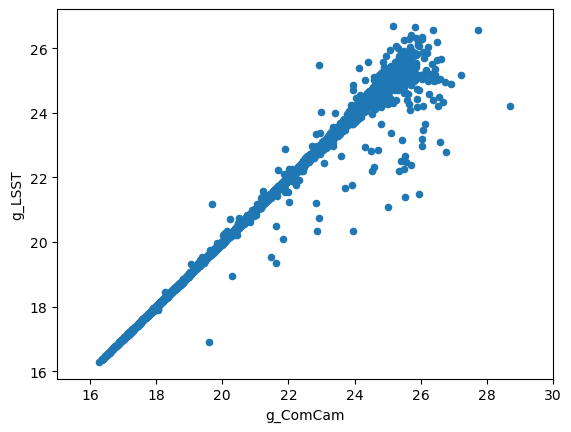

In [36]:
df.plot('g_ComCam', 'g_LSST', kind='scatter')
plt.xlim([15,30.])

## 9. Create Initial Mask

In [37]:
## Old version:
#mask1 = df["g_LSST"] > 0.
#mask2 = df["r_LSST"] > 0.
#mask3 = df["i_LSST"] > 0.
#mask4 = df["z_LSST"] > 0.
#mask5 = df["y_LSST"] > 0.
#mask6 = df["g_err_LSST"] <= 0.02
#mask7 = df["r_err_LSST"] <= 0.02
#mask8 = df["i_err_LSST"] <= 0.02
#mask9 = df["z_err_LSST"] <= 0.02
#mask10 = df["y_err_LSST"] <= 0.02
#mask_LSST = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10
#
#mask1 = df["g_ComCam"] > 0.
#mask2 = df["r_ComCam"] > 0.
#mask3 = df["i_ComCam"] > 0.
#mask4 = df["z_ComCam"] > 0.
#mask5 = df["y_ComCam"] > 0.
#mask6 = df["g_err_ComCam"] <= 0.02
#mask7 = df["r_err_ComCam"] <= 0.02
#mask8 = df["i_err_ComCam"] <= 0.02
#mask9 = df["z_err_ComCam"] <= 0.02
#mask10 = df["y_err_ComCam"] <= 0.02
#mask_ComCam = mask1 & mask2 & mask3 & mask4 & mask5 & mask6 & mask7 & mask8 & mask9 & mask10
#
#mask = mask_LSST & mask_ComCam


In [38]:
# Create masks, ignoring any flux or fluxerr column that ONLY contains negative values 
#  (e.g., cases where a field was not observed in a given filter band)...
# Kudos to CoPilot + GPT-5.
def build_mask(df, suffix):
    # flux columns for this instrument
    flux_cols = [f"{b}_{suffix}" for b in ["g","r","i","z","y"] if f"{b}_{suffix}" in df.columns]
    err_cols  = [f"{b}_err_{suffix}" for b in ["g","r","i","z","y"] if f"{b}_err_{suffix}" in df.columns]

    # keep only those flux columns that have at least one positive value
    flux_cols = [c for c in flux_cols if (df[c] > 0).any()]
    # keep only those error columns that have at least one value ≤ 0.02
    err_cols  = [c for c in err_cols if (df[c] <= 0.02).any()]

    # start with all True, then AND in each condition
    mask = pd.Series(True, index=df.index)
    for c in flux_cols:
        mask &= df[c] > 0
    for c in err_cols:
        mask &= df[c] <= 0.02
    return mask

mask_LSST   = build_mask(df, "LSST")
mask_ComCam = build_mask(df, "ComCam")

mask = mask_LSST & mask_ComCam


## 10. Make Backup Copies of Initial Mask and Original Data Frame

In [39]:
# Make a backup copy of original df...
df_orig = df.copy()

# Make a backup copy of original mask...
mask_orig = mask.copy()

In [40]:
df

,tractId,field,RA_ComCam,DEC_ComCam,u_psfFlux,u_psfFluxErr,u_ap12Flux,u_ap12FluxErr,u_extendedness,u_psfFlux_flag,...,ri_ComCam,iz_ComCam,zy_ComCam,gi_ComCam,gr_LSST,ri_LSST,iz_LSST,zy_LSST,gi_LSST,dmag
9989,4849,ECDFS,53.305439,-28.694426,102.622742,362.713531,202.669632,746.471375,NaN,False,...,1.000391,10021.061523,0.000000,1.982399,1.099613,1.005630,0.394018,10020.686523,2.105244,-9999.0
9990,4849,ECDFS,53.271986,-28.674615,13477.228516,417.236908,14691.198242,766.648560,0.0,False,...,0.123705,0.069721,10018.694336,0.506424,0.390009,0.158733,0.024000,10018.710938,0.548742,-9999.0
9993,4849,ECDFS,53.325036,-28.698507,NaN,NaN,207.160324,inf,NaN,True,...,0.171432,10017.396484,0.000000,0.632809,0.466986,0.180151,0.043892,10017.346680,0.647137,-9999.0
9994,4849,ECDFS,53.278364,-28.686724,2820.904053,378.298584,3341.103027,757.997681,1.0,False,...,1.154894,0.497795,10016.490234,2.379707,1.178730,1.167206,0.489649,10016.498047,2.345936,-9999.0
9996,4849,ECDFS,53.285193,-28.677182,13077.781250,419.588928,13689.464844,767.839722,0.0,False,...,0.226561,0.115387,10017.931641,0.787153,0.569502,0.235554,0.074062,10017.959961,0.805056,-9999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30320,2234,EDFS,58.592220,-49.108123,551.590210,354.660004,542.824463,598.304749,NaN,False,...,0.123802,0.073187,0.119724,0.606445,0.449053,0.210558,0.044334,10021.050781,0.659611,-9999.0
30324,2234,EDFS,58.497784,-49.105854,NaN,NaN,294.932404,10.994769,NaN,True,...,1.768970,0.814960,0.375481,3.128712,1.336800,1.747652,0.795893,10017.994141,3.084452,-9999.0
30325,2234,EDFS,58.479871,-49.101866,NaN,NaN,294.934540,10.993175,NaN,True,...,1.516380,0.690481,0.296095,3.071850,1.422733,1.494562,0.653027,10019.330078,2.917295,-9999.0
30326,2234,EDFS,58.511756,-49.099982,NaN,NaN,294.933624,10.999981,NaN,True,...,0.042055,0.023129,-0.060734,0.291180,0.233299,0.094753,-0.002583,10019.789062,0.328053,-9999.0


In [41]:
#df_orig[df_orig.u_LSST>0.0].plot('RA_ComCam','DEC_ComCam',kind='scatter')

## 11. Run Fit in Each Filter Band




# # # # # # # # # # # # # # # # # # # # 
g_ComCam
# # # # # # # # # # # # # # # # # # # # 

g_ComCam [-10.0, 10.0] 1


count     4507.000000
mean         1.699622
std          0.786956
min         -0.551304
0.01%       -0.525881
50%          1.874619
99.99%       3.641552
max          3.704552
Name: gi_LSST, dtype: float64

g_ComCam [-0.6, 3.7] 1
*********************************
0 -0.6 3.7
*********************************
mask_branch length (before): 4507
dmag_branch length: 4506
color1_branch length: 4506
4506 4506 4506
4291 4291 4506
4294 4294 4506
4294 4294 4506
mask_branch length (after): 4507
p_1 = 0.015748 ± 0.000256
p_0 = -0.010765 ± 0.000474

g_ComCam - g_LSST = -0.011 + 0.016*$(g-i)_{LSST}$ [-0.6 < $(g-i)_{LSST}$ <= 3.7] [rms: 0.013]
g_ComCam - g_LSST = +0.016*$(g-i)_{LSST}$ -0.011  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.013]

g_ComCam - g_LSST = +0.016*$(g-i)_{LSST}$ -0.011  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.013]

g_LSST --> g_ComCam

g_ComCam - g_LSST = +0.016*$(g-i)_{LSST}$ -0.011  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.013]




# # # # # # # # # # # # # # # # # # # # 
r_ComCam
# # # # # # # # # # # # # # # # # # # # 

r_ComCam [-10.0, 10.0] 1


count     4507.000000
mean         1.699622
std          0.786956
min         -0.551304
0.01%       -0.525881
50%          1.874619
99.99%       3.641552
max          3.704552
Name: gi_LSST, dtype: float64

r_ComCam [-0.6, 3.7] 1
*********************************
0 -0.6 3.7
*********************************
mask_branch length (before): 4507
dmag_branch length: 4506
color1_branch length: 4506
4506 4506 4506
4283 4283 4506
4282 4282 4506
4281 4281 4506
4282 4282 4506
4282 4282 4506
mask_branch length (after): 4507
p_1 = -0.000893 ± 0.000163
p_0 = 0.000024 ± 0.000304

r_ComCam - r_LSST = 0.000 + -0.001*$(g-i)_{LSST}$ [-0.6 < $(g-i)_{LSST}$ <= 3.7] [rms: 0.008]
r_ComCam - r_LSST = -0.001*$(g-i)_{LSST}$ +0.000  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.008]

r_ComCam - r_LSST = -0.001*$(g-i)_{LSST}$ +0.000  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.008]

r_LSST --> r_ComCam

r_ComCam - r_LSST = -0.001*$(g-i)_{LSST}$ +0.000  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.008]




# # # # # # # # # # # # # # # # # # # # 
i_ComCam
# # # # # # # # # # # # # # # # # # # # 

i_ComCam [-10.0, 10.0] 1


count     4507.000000
mean         1.699622
std          0.786956
min         -0.551304
0.01%       -0.525881
50%          1.874619
99.99%       3.641552
max          3.704552
Name: gi_LSST, dtype: float64

i_ComCam [-0.6, 3.7] 1
*********************************
0 -0.6 3.7
*********************************
mask_branch length (before): 4507
dmag_branch length: 4506
color1_branch length: 4506
4506 4506 4506
4359 4359 4506
4346 4346 4506
4344 4344 4506
4344 4344 4506
mask_branch length (after): 4507
p_1 = -0.010532 ± 0.000132
p_0 = 0.022110 ± 0.000248

i_ComCam - i_LSST = 0.022 + -0.011*$(g-i)_{LSST}$ [-0.6 < $(g-i)_{LSST}$ <= 3.7] [rms: 0.007]
i_ComCam - i_LSST = -0.011*$(g-i)_{LSST}$ +0.022  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.007]

i_ComCam - i_LSST = -0.011*$(g-i)_{LSST}$ +0.022  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.007]

i_LSST --> i_ComCam

i_ComCam - i_LSST = -0.011*$(g-i)_{LSST}$ +0.022  [-0.6 < $(g-i)_{LSST}$ <= 3.7]  [rms: 0.007]




# # # # # # # # # # # # # # # # # # # # 
z_ComCam
# # # # # # # # # # # # # # # # # # # # 

z_ComCam [-10.0, 10.0] 1


count     4507.000000
mean         0.293055
std          0.218855
min         -0.256069
0.01%       -0.244199
50%          0.277735
99.99%       1.003105
max          1.013252
Name: iz_LSST, dtype: float64

z_ComCam [-0.3, 1.1] 1
*********************************
0 -0.3 1.1
*********************************
mask_branch length (before): 4507
dmag_branch length: 4507
color1_branch length: 4507
4507 4507 4507
4264 4264 4507
4214 4214 4507
4211 4211 4507
4211 4211 4507
4211 4211 4507
mask_branch length (after): 4507
p_1 = -0.003020 ± 0.000570
p_0 = -0.007748 ± 0.000209

z_ComCam - z_LSST = -0.008 + -0.003*$(i-z)_{LSST}$ [-0.3 < $(i-z)_{LSST}$ <= 1.1] [rms: 0.008]
z_ComCam - z_LSST = -0.003*$(i-z)_{LSST}$ -0.008  [-0.3 < $(i-z)_{LSST}$ <= 1.1]  [rms: 0.008]

z_ComCam - z_LSST = -0.003*$(i-z)_{LSST}$ -0.008  [-0.3 < $(i-z)_{LSST}$ <= 1.1]  [rms: 0.008]

z_LSST --> z_ComCam

z_ComCam - z_LSST = -0.003*$(i-z)_{LSST}$ -0.008  [-0.3 < $(i-z)_{LSST}$ <= 1.1]  [rms: 0.008]

| Conversion                | Transformation Equation                              |   RMS | Applicable Color Range         | QA Plot                                                                                      |
|:-------

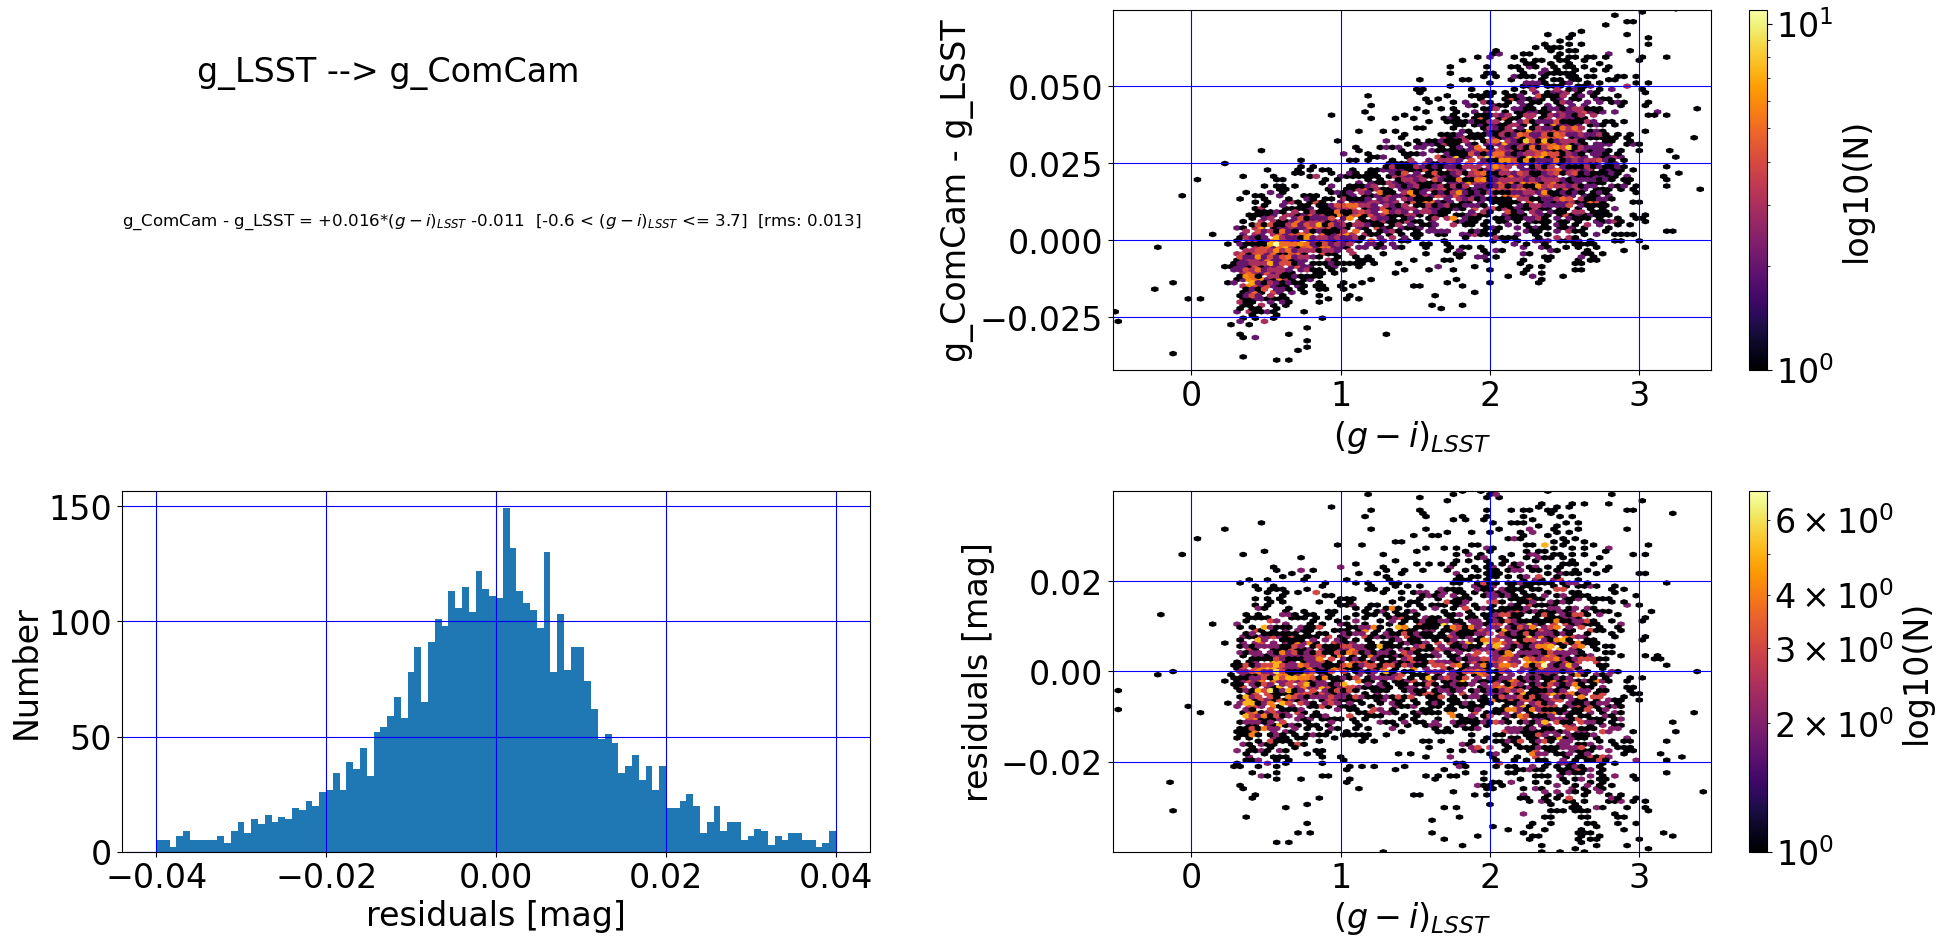

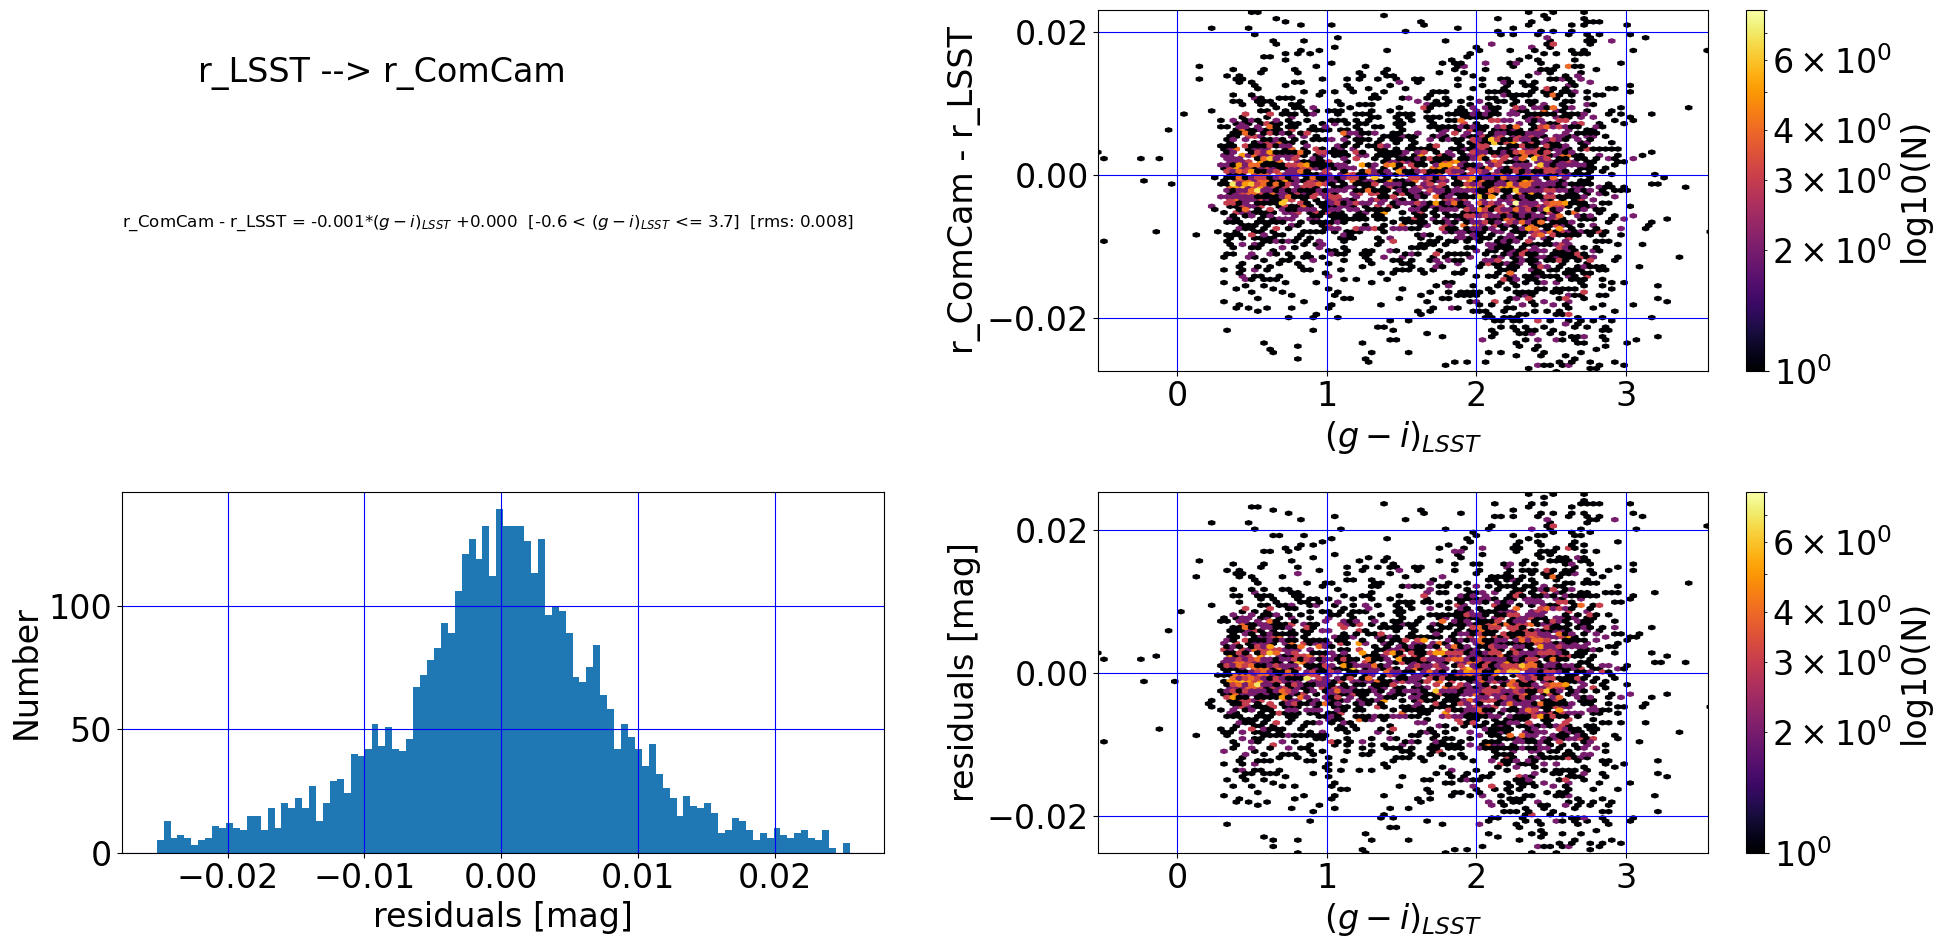

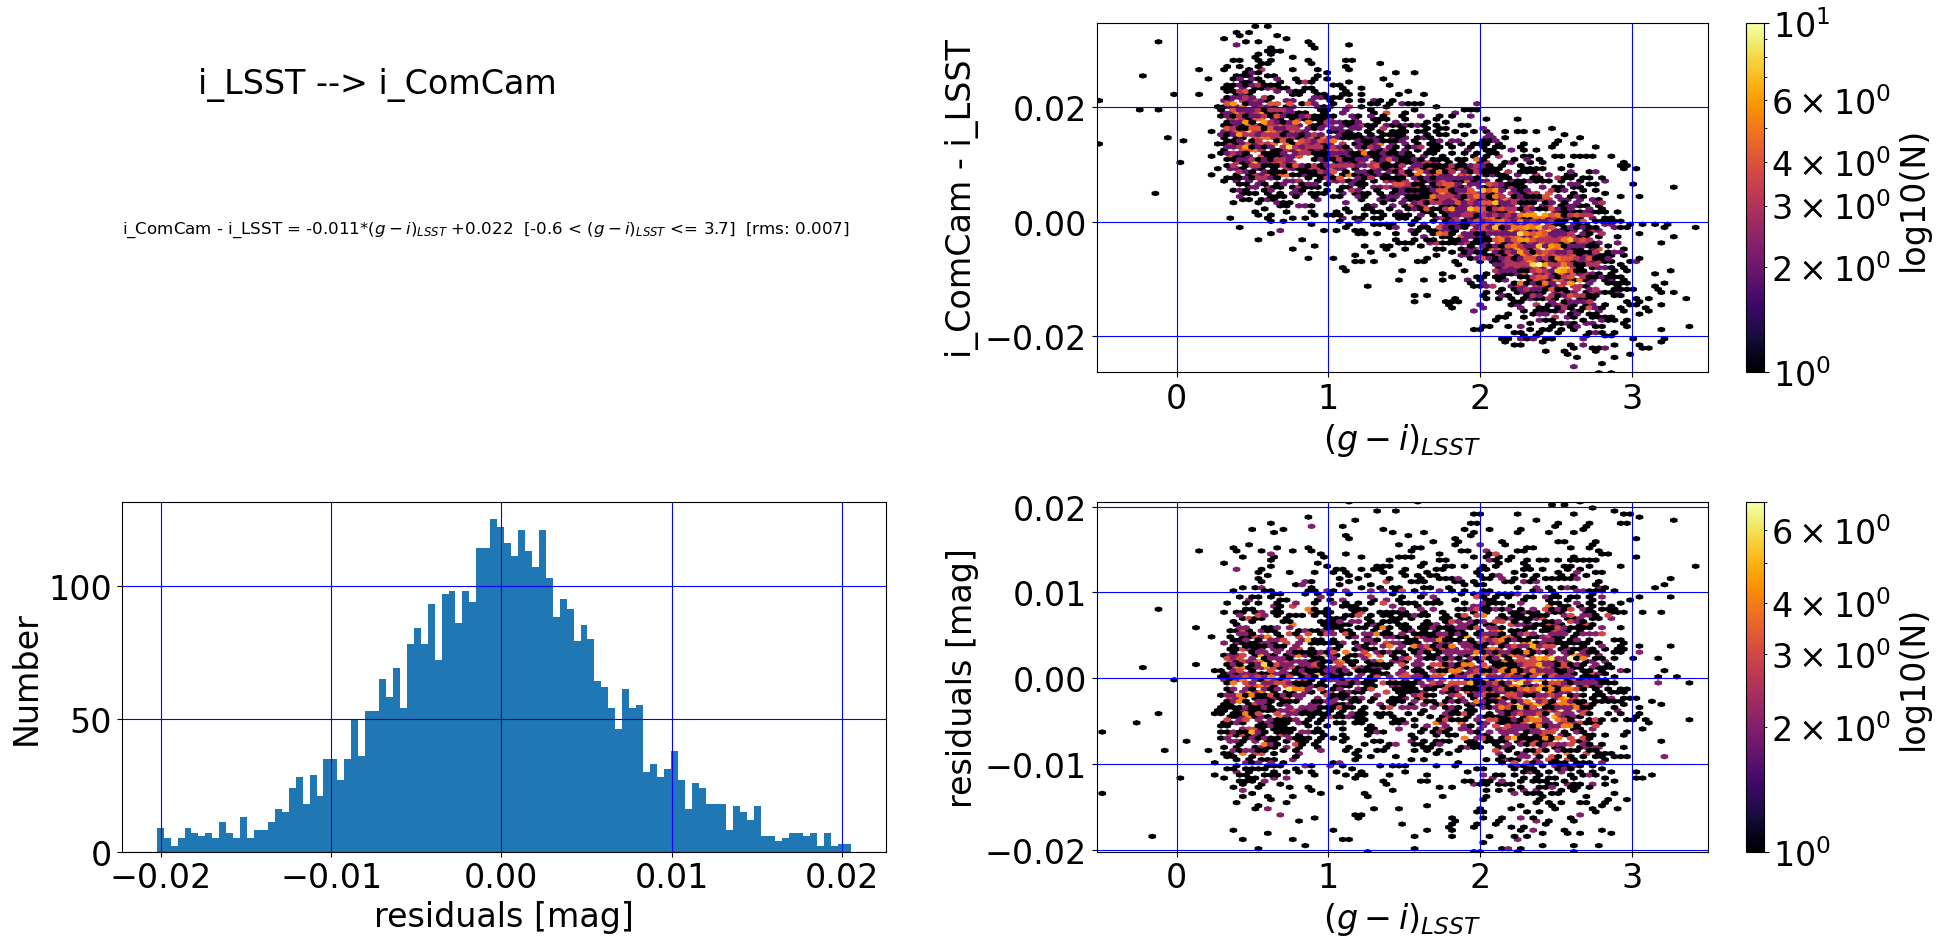

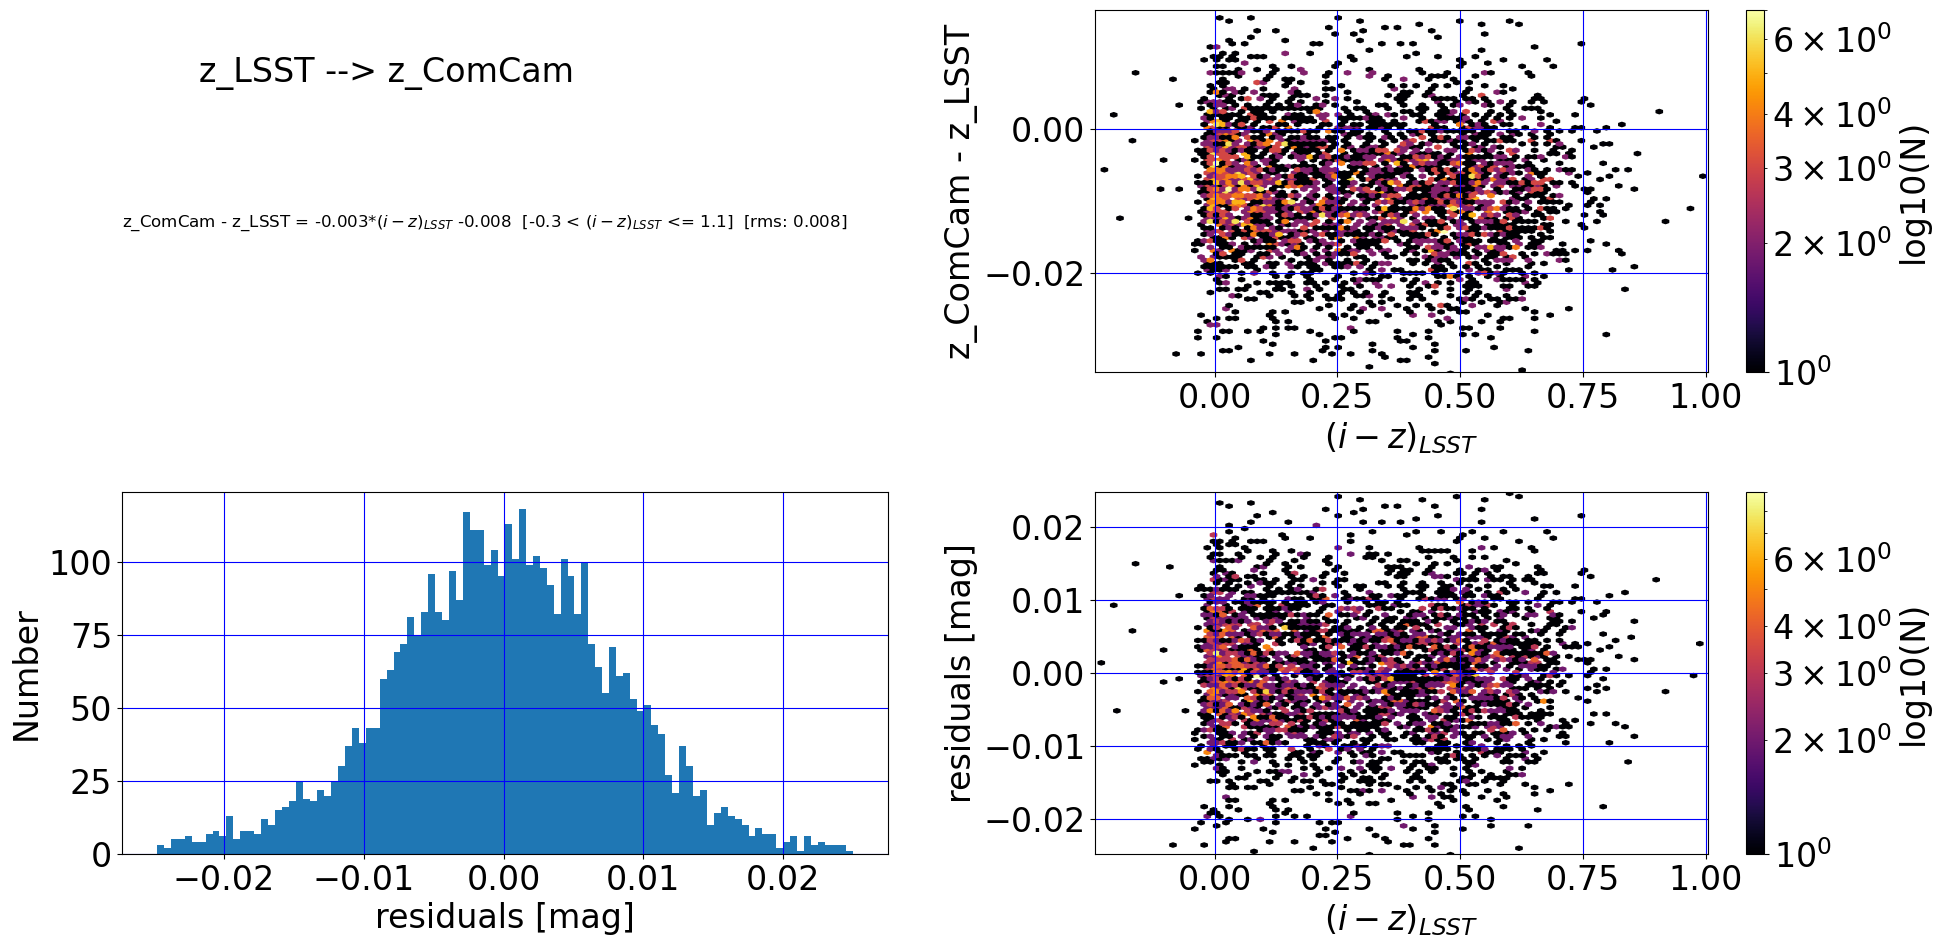

In [42]:

# --- Accumulator for ALL bands ---
qa_rows_all = []

# --- Main loop ---
for band in bandList:

    print("\n\n\n" + "# " * 20)
    print(band)
    print("# " * 20 + "\n")

    magName = band
    magName_match = matchBand_dict[band]
    color_name_1 = color_name_1_dict[band]
    colorLabel_1 = colorLabel_1_dict[band]

    # Create title/names for use in QA plots...
    title = f"{magName_match} --> {magName}"
    dmagName = f"{magName} - {magName_match}"

    # Grab the original version of df from the backup copy...
    df = df_orig.copy()

    # Grab the original version of mask from the backup copy...
    mask = mask_orig.copy()

    # Update dmag column for {$band} - {$band}_match...
    df.loc[:, 'dmag'] = df.loc[:, magName] - df.loc[:, magName_match]

    # Update mask...
    mask1 = (abs(df['dmag']) <= 10.)
    mask2 = ((df[color_name_1] > -3.) & (df[color_name_1] < 6.0))
    mask = mask & mask1 & mask2
    df = df[mask]

    # Calculate number of disjoint branches to fit...
    nbranches = len(color_limits_1_dict[band]) - 1
    if verbose > 0:
        print(band, color_limits_1_dict[band], nbranches)

    # Reset bluest color limit in bluest branch to color1_min
    #  and reddest color limit in reddest branch to color1_max, 
    #  after excluding above mask...
    dftmp = df
    color1_desc = dftmp[color_name_1].describe(percentiles=[0.0001, 0.9999])
    display(color1_desc)
    color1_min = math.floor(10*(color1_desc['0.01%']-0.05))/10.
    color1_max = math.ceil(10*(color1_desc['99.99%']+0.05))/10.
    color_limits_1_dict[band][0] = color1_min
    color_limits_1_dict[band][nbranches] = color1_max
    if verbose > 0:
        print(band, color_limits_1_dict[band], nbranches)

    # Iterate, with sigma-clipping...
    color1_list = []
    dmag_list = []
    res_list = []
    mask_list = []
    plot1Text = ''

    for ibranch in range(nbranches):

        print('*********************************')
        print(ibranch, color_limits_1_dict[band][ibranch], color_limits_1_dict[band][ibranch+1])
        print('*********************************')

        mask_branch = ((df[color_name_1] > color_limits_1_dict[band][ibranch]) &
                       (df[color_name_1] <= color_limits_1_dict[band][ibranch+1]))
        df_branch = df[mask_branch].copy()

        # ... and extract dmag's and color1's for this branch...
        dmag_branch = df_branch.loc[:, 'dmag']
        color1_branch = df_branch.loc[:, color_name_1]

        # If there are no valid colors on this branch, continue to next branch...
        if len(color1_branch) < 1:
            continue

        # Perform fit for each disjoint branch...
        print("mask_branch length (before):", len(mask_branch))
        print("dmag_branch length:", len(dmag_branch))
        print("color1_branch length:", len(color1_branch))

        p_branch, perr_branch, color1_branch, dmag_branch, res_branch, stddev_branch = \
            poly_fit_with_sigma_clip(color1_branch, dmag_branch, degree=norder)

        print("mask_branch length (after):", len(mask_branch))

        # Print coefficients and estimated statistical errors in the coefficients
        for i, (p, perr) in enumerate(zip(p_branch, perr_branch)):
            print(f'p_{len(p_branch)-i-1} = {p:.6f} ± {perr:.6f}')

        # --- Build Markdown table row and add to global list ---
        eq_str = make_eq_str(dmagName, p_branch, colorLabel_1, norder)
        range_str = make_range_str(color_limits_1_dict[band], colorLabel_1, ibranch)
        outputFileName = make_output_filename(
            qaFileBaseName, magName, magName_match, color_name_1, norder
        )
        link_str = f"[link](_static/plots/{outputFileName})"
        title_math = latexify_name(title)
        title_math = title_math.replace("-->", "\\to")
        qa_rows_all.append({
            "Conversion": f"${title_math}$",
            "Transformation Equation": eq_str,
            "RMS": round(stddev_branch, 3),
            "Applicable Color Range": range_str,
            "QA Plot": link_str
        })

        # Keep original plot1Text for QA plots
        if norder == 1:
            plot1Text1 = f"{dmagName} = {p_branch[1]:.3f} + {p_branch[0]:.3f}*{colorLabel_1} " \
                         f"[{color_limits_1_dict[band][ibranch]:.1f} < {colorLabel_1} <= {color_limits_1_dict[band][ibranch+1]:.1f}] " \
                         f"[rms: {stddev_branch:.3f}]"
        elif norder == 2:
            plot1Text1 = f"{dmagName} = {p_branch[2]:.3f} + {p_branch[1]:.3f}*{colorLabel_1} " \
                         f"+ {p_branch[0]:.3f}*{colorLabel_1}^2  " \
                         f"[{color_limits_1_dict[band][ibranch]:.1f} < {colorLabel_1} <= {color_limits_1_dict[band][ibranch+1]:.1f}] " \
                         f"[rms: {stddev_branch:.3f}]"
        else:
            plot1Text1 = ''

        plot1Text1_old = f"{plot1Text}\n{plot1Text1}"
        print(plot1Text1_old)

        plot1Text1 = make_plot_text(
            dmagName, p_branch, colorLabel_1, norder,
            color_limits_1_dict[band], ibranch, stddev_branch
        )
        plot1Text = f"{plot1Text}\n{plot1Text1}"
        print(plot1Text1)
        print(plot1Text)


        # Append branch df and mask to the df_list and mask_list lists, respectively...
        #df_list.append(df_branch.copy())
        #mask_list.append(mask_branch.copy())
        color1_list.append(color1_branch.copy())
        dmag_list.append(dmag_branch.copy())
        res_list.append(res_branch.copy())
        mask_list.append(mask_branch.copy())

    # Concatenate the color1, dmag, res, and mask lists for all the branches...
    color1 = pd.Series(np.concatenate(color1_list))
    dmag = pd.Series(np.concatenate(dmag_list))
    res = pd.Series(np.concatenate(res_list))
    mask = pd.Series(np.concatenate(mask_list))

    # Calculate the standard deviation for the full piecewise fit...
    stddev = res.std()

    # Output best fits to screen...
    if verbose > 0:
        print("")
        print(title)
        print(plot1Text)
        print("")

    # Create QA plots...
    outputFileName = make_output_filename(
        qaFileBaseName, magName, magName_match, color_name_1, norder
    )
    status = transform1ColorQAPlots1a(
        dmag, color1, res, norder, title, plot1Text,
        dmagName, colorLabel_1, stddev, outputFileName
    )

# --- After ALL bands processed: display one big table ---
if qa_rows_all:
    qa_df_all = pd.DataFrame(qa_rows_all)
    # Generate Markdown string (older Pandas: escape removal trick)
    md_table_str = qa_df_all.to_markdown(index=False)
    md_table_str = md_table_str.replace(r'\_', '_')
    print(md_table_str)  # raw Markdown table source

    if write_md_file:
        with open(md_filename, "w") as f:
            f.write(md_table_str)
        print(f"\nMarkdown table written to: {md_filename}")



In [43]:
raise StopExecution

## 12.  Sandbox

In [ ]:
# Example with plotting
import matplotlib.pyplot as plt

band = 'g'

magName_ComCam = """%s_ComCam""" % (band)
magErrName_ComCam = """%s_err_ComCam""" % (band)
magName_ps1 = """%s_ps1""" % (band)
magErrName_ps1 = """%s_err_ps1""" % (band)
    
# Grab the original version of df from the backup copy...
df = df_orig.copy()

# Grab the original version of mask from the backup copy...
mask = mask_orig.copy()

# Update dmag column for {$band}_des - {$band}_ComCam...
if toComCam:
    df.loc[:,'dmag'] = df.loc[:,magName_ComCam] - df.loc[:,magName_ps1]
else:
    df.loc[:,'dmag'] = df.loc[:,magName_ps1] - df.loc[:,magName_ComCam]
        
# Update mask...
mask1 = abs(df['dmag']) <= 10.
mask2 = abs(df[magErrName_ComCam]) <= 0.02
mask3 = abs(df[magErrName_ps1]) <= 0.01
mask = mask & mask1 & mask2 & mask3

# make a copy of original df, overwriting the old one...
df = df[mask].copy()

# Identify dmag and color1 series...
dmag =  df.loc[:,'dmag']
color1 = df.loc[:,color_name_1]


color1_array = color1
dmag_array = dmag

# Perform the fit
coeffs, mask, res, rms = poly_fit_with_sigma_clip(color1_array, dmag_array, degree=1)

# Generate smooth curve for plotting
x_smooth = np.linspace(min(color1_array), max(color1_array), 100)
y_smooth = np.polyval(coeffs, x_smooth)

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(color1_array[mask], dmag_array[mask], label='Used points')
plt.scatter(color1_array[~mask], dmag_array[~mask], color='red', label='Rejected points')
plt.plot(x_smooth, y_smooth, 'k-', label='Fit')
plt.xlabel('Color')
plt.ylabel('dmag')
plt.legend()
plt.title(f'Polynomial fit (RMS = {rms:.3f})')
plt.show()

# Print coefficients
for i, c in enumerate(coeffs):
    print(f'c_{len(coeffs)-i-1} = {c:.6f}')